# CitiBike Geospatial Plotting

## Table of Contents
01. Libraries/Imports
02. Data Inspection
03. Station‑to‑Station Trip Counts
04. Brief EDA
05. Mapping 

## 01. Libraries/Imports

In [1]:
import pandas as pd
import os
from keplergl import KeplerGl
from pyproj import CRS
import numpy as np
from matplotlib import pyplot as plt

C:\Users\Chase\anaconda3\envs\CitiBike\Lib\site-packages\keplergl\keplergl.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


In [2]:
# Import merged csv
ny_data_merged_v2 = pd.read_csv("../02_Data/Prepared_Data/ny_data_merged_v2.csv")

C:\Users\Chase\AppData\Local\Temp\ipykernel_10188\1979977056.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  ny_data_merged_v2 = pd.read_csv("../02_Data/Prepared_Data/ny_data_merged_v2.csv")


## 02. Data Inspection

In [3]:
ny_data_merged_v2.shape

(29838166, 19)

In [4]:
ny_data_merged_v2.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'date', 'avgTemp', '_merge', 'bike_rides_daily',
       'value', 'tripduration'],
      dtype='object')

In [5]:
ny_data_merged_v2.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,date,avgTemp,_merge,bike_rides_daily,value,tripduration
0,4A091640AEC83471,classic_bike,2022-01-01 16:01:22.082,2022-01-01 16:05:11.986,S 4 St & Wythe Ave,5204.05,Kent Ave & S 11 St,5062.01,40.712859,-73.965903,40.707645,-73.968415,member,2022-01-01,11.6,both,20428,1,3.831733
1,7A560D6287C00126,classic_bike,2022-01-01 14:07:04.344,2022-01-01 14:31:57.500,Lexington Ave & E 120 St,7652.04,Amsterdam Ave & W 125 St,7800.03,40.801307,-73.939817,40.813358,-73.956461,member,2022-01-01,11.6,both,20428,1,24.885933
2,4F6F726B809C15E4,classic_bike,2022-01-01 12:02:26.943,2022-01-01 12:14:13.555,Lexington Ave & E 120 St,7652.04,Amsterdam Ave & W 125 St,7800.03,40.801307,-73.939817,40.813358,-73.956461,member,2022-01-01,11.6,both,20428,1,11.776867
3,3BC10DC94FD79955,classic_bike,2022-01-01 22:53:23.508,2022-01-01 23:18:42.881,Cleveland Pl & Spring St,5492.05,Mott St & Prince St,5561.04,40.722104,-73.997249,40.723180,-73.994800,member,2022-01-01,11.6,both,20428,1,25.322883
4,FE4CE7F1CFFD7952,classic_bike,2022-01-01 08:04:51.755,2022-01-01 08:08:07.290,Central Park North & Adam Clayton Powell Blvd,7617.07,E 110 St & Madison Ave,7587.14,40.799484,-73.955613,40.796154,-73.947821,member,2022-01-01,11.6,both,20428,1,3.258917


In [6]:
ny_data_merged_v2.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
date                   object
avgTemp               float64
_merge                 object
bike_rides_daily        int64
value                   int64
tripduration          float64
dtype: object

## 03. Station Routes and Trip Counts

### Coordinate Cleanup

In [7]:
# Simplified coordinate cleanup
station_lookup = (
    ny_data_merged_v2[
        ["start_station_name", "end_station_name",
         "start_lat", "start_lng", "end_lat", "end_lng"]
    ]
    .dropna()
    .drop_duplicates(subset=["start_station_name", "end_station_name"])
)

In [8]:
# Work check
station_lookup.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1013397 entries, 0 to 29838148
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   start_station_name  1013397 non-null  object 
 1   end_station_name    1013397 non-null  object 
 2   start_lat           1013397 non-null  float64
 3   start_lng           1013397 non-null  float64
 4   end_lat             1013397 non-null  float64
 5   end_lng             1013397 non-null  float64
dtypes: float64(4), object(2)
memory usage: 54.1+ MB


In [9]:
# Work check
station_lookup.head()

,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng
0,S 4 St & Wythe Ave,Kent Ave & S 11 St,40.712859,-73.965903,40.707645,-73.968415
1,Lexington Ave & E 120 St,Amsterdam Ave & W 125 St,40.801307,-73.939817,40.813358,-73.956461
3,Cleveland Pl & Spring St,Mott St & Prince St,40.722104,-73.997249,40.723180,-73.994800
4,Central Park North & Adam Clayton Powell Blvd,E 110 St & Madison Ave,40.799484,-73.955613,40.796154,-73.947821
6,E 2 St & 2 Ave,Allen St & Rivington St,40.725029,-73.990697,40.720196,-73.989978


In [10]:
# Work check
station_lookup.isna().sum()

start_station_name    0
end_station_name      0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
dtype: int64

In [11]:
# Work check on duplicates
station_lookup.duplicated(subset=["start_station_name", "end_station_name"]).sum()

np.int64(0)

### Aggregate trips by station name

In [12]:
# Station to Station Trip counts
df_routes = (
    ny_data_merged_v2
    .groupby(["start_station_name", "end_station_name"])
    .size()
    .reset_index(name="trip_count")
)

In [29]:
# Merge coordinate data back in
df_routes = df_routes.merge(
    station_lookup,
    on=["start_station_name", "end_station_name"],
    how="left"
)

In [30]:
df_routes.shape

(1013397, 7)

In [31]:
# Work check
df_routes.head()

,start_station_name,end_station_name,trip_count,start_lat,start_lng,end_lat,end_lng
0,1 Ave & E 110 St,1 Ave & E 110 St,791,40.792327,-73.9383,40.792327,-73.938300
1,1 Ave & E 110 St,1 Ave & E 18 St,2,40.792327,-73.9383,40.733812,-73.980544
2,1 Ave & E 110 St,1 Ave & E 30 St,4,40.792327,-73.9383,40.741444,-73.975361
3,1 Ave & E 110 St,1 Ave & E 39 St,1,40.792327,-73.9383,40.747140,-73.971130
4,1 Ave & E 110 St,1 Ave & E 44 St,12,40.792327,-73.9383,40.750020,-73.969053


In [32]:
# Check for missing stations
df_routes.isna().sum()

start_station_name    0
end_station_name      0
trip_count            0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
dtype: int64

### Select top 500 routes

In [33]:
# Sort the top 500
df_top500 = (
    df_routes
    .sort_values("trip_count", ascending=False)
    .head(500)
    .reset_index(drop=True)
)

In [34]:
# Work check
df_top500.head(20)

,start_station_name,end_station_name,trip_count,start_lat,start_lng,end_lat,end_lng
0,Central Park S & 6 Ave,Central Park S & 6 Ave,12041,40.765909,-73.976342,40.765909,-73.976342
1,7 Ave & Central Park South,7 Ave & Central Park South,8541,40.766741,-73.979069,40.766741,-73.979069
2,Roosevelt Island Tramway,Roosevelt Island Tramway,8213,40.757284,-73.953600,40.757284,-73.953600
3,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S,7287,40.764397,-73.973715,40.764397,-73.973715
4,Soissons Landing,Soissons Landing,7275,40.692317,-74.014866,40.692317,-74.014866
5,W 21 St & 6 Ave,9 Ave & W 22 St,6345,40.741740,-73.994156,40.745497,-74.001971
6,5 Ave & E 72 St,5 Ave & E 72 St,6037,40.772828,-73.966853,40.772828,-73.966853
7,1 Ave & E 62 St,1 Ave & E 68 St,5826,40.761227,-73.960940,40.765005,-73.958185
8,Yankee Ferry Terminal,Yankee Ferry Terminal,5759,40.687066,-74.016756,40.687066,-74.016756
9,Broadway & W 58 St,Broadway & W 58 St,5509,40.766953,-73.981693,40.766953,-73.981693


### Export Top 500 Routes

In [35]:
# Export to csv
df_top500.to_csv(
    r"..\02_Data\Prepared_Data\top500_routes.csv",
    index=False
)

## 04. Brief EDA

In [20]:
# Basic info on the new subset

stats = df_routes['trip_count'].describe()

print(f"Count: {stats['count']:,.0f}")
print(f"Mean: {stats['mean']:,.2f}")
print(f"Std Dev: {stats['std']:,.2f}")
print(f"Min: {stats['min']:,.0f}")
print(f"25%: {stats['25%']:,.0f}")
print(f"50% (Median): {stats['50%']:,.0f}")
print(f"75%: {stats['75%']:,.0f}")
print(f"Max: {stats['max']:,.0f}")

Count: 1,013,397
Mean: 29.37
Std Dev: 99.25
Min: 1
25%: 1
50% (Median): 4
75%: 17
Max: 12,041


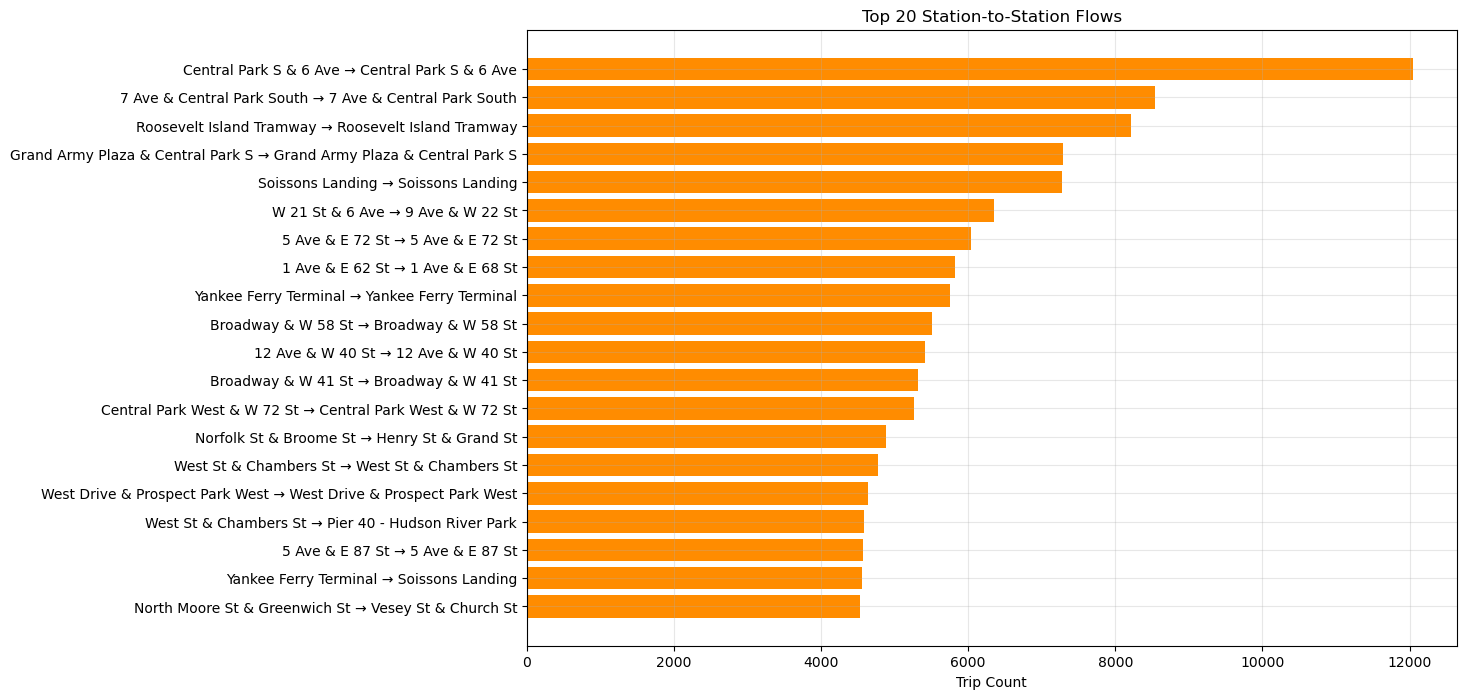

In [21]:
top20 = df_routes.sort_values('trip_count', ascending=False).head(20)

plt.figure(figsize=(12,8))
plt.barh(
    top20['start_station_name'] + " → " + top20['end_station_name'],
    top20['trip_count'],
    color='darkorange'
)
plt.title("Top 20 Station-to-Station Flows")
plt.xlabel("Trip Count")
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.show()

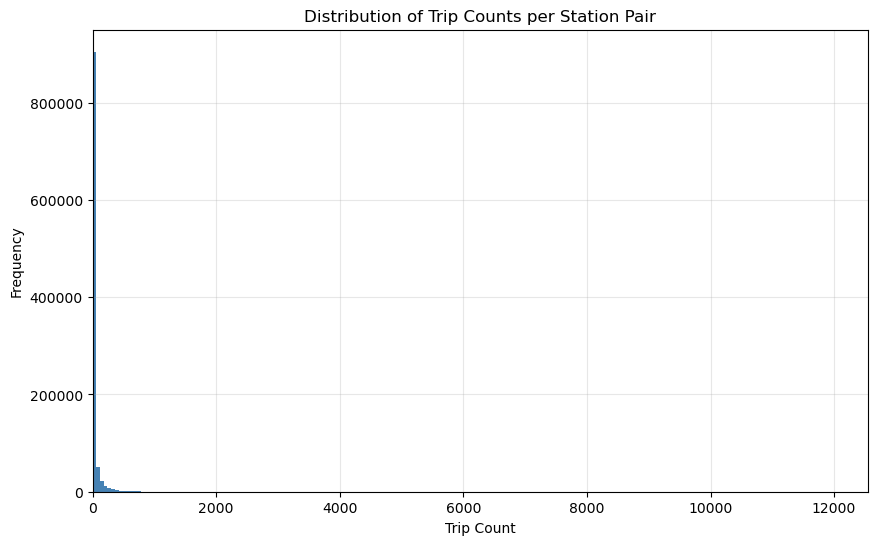

In [23]:
max_val = df_routes['trip_count'].max()

plt.figure(figsize=(10,6))
plt.hist(df_routes['trip_count'], bins=200, color='steelblue')
plt.xlim(0, max_val + 500)   # extend slightly past the max
plt.title("Distribution of Trip Counts per Station Pair")
plt.xlabel("Trip Count")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

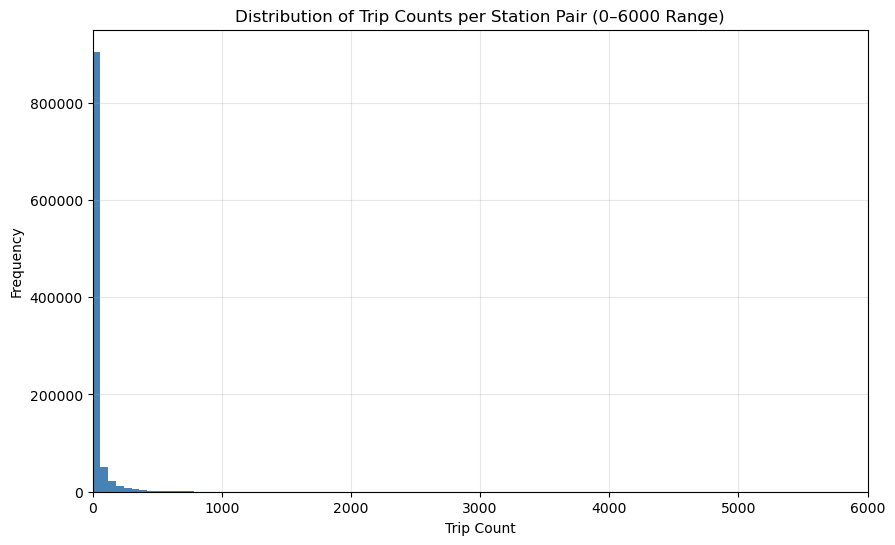

In [24]:
# Focused Histogram (MAX= 6,000)
 
plt.figure(figsize=(10,6))
plt.hist(df_routes['trip_count'], bins=200, color='steelblue')
plt.xlim(0, 6000)
plt.title("Distribution of Trip Counts per Station Pair (0–6000 Range)")
plt.xlabel("Trip Count")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

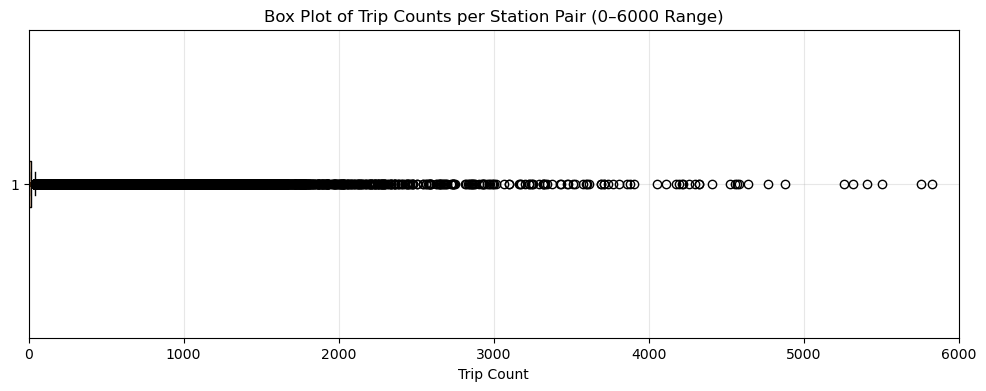

In [25]:
# Focused Box Plot (MAX= 6,000)

plt.figure(figsize=(12,4))
plt.boxplot(df_routes['trip_count'], vert=False)
plt.xlim(0, 6000)
plt.title("Box Plot of Trip Counts per Station Pair (0–6000 Range)")
plt.xlabel("Trip Count")
plt.grid(alpha=0.3)
plt.show()

## 05. Mapping

In [26]:
# Start the map
map_1 = KeplerGl(height=600)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [27]:
# Add the top 500 routes
map_1.add_data(data=df_top500, name="Top 500 Routes")

In [28]:
# Plot the map
from IPython.display import display
display(map_1)

C:\Users\Chase\anaconda3\envs\CitiBike\Lib\site-packages\IPython\core\formatters.py:429: FormatterWarning: text/html formatter returned invalid type <class 'bytes'> (expected <class 'str'>) for object: KeplerGl(data={'Top 500 Routes': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,

KeplerGl(data={'Top 500 Routes': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, …

I was unable to edit the map in JupyterLab due to an error. So I built it into the KeplerGl website instead.

#### Edits to the Map

The changes I made to the map were the following:
- Start and End points are now white
- In the Arc layer, I set the field for color and stroke to trip_count
- In the arc layer, I kept it quantile and changed the color scale to: Teal to Orange

These changes will make it easier to read the map and understand where the most frequent trips took place.

Using the trip_count filter on the map, the most common trip routes in New York City appear as single points rather than arcs. It seems the highest volume of trips is the start and end locations, basically looping. The top trip volume areas seem to be heavy tourist areas with Central Park having 3 of the top 5 locations. 